# MOD17A3HGF.061: Terra Net Primary Production Gap-Filled Yearly Global 500m

We have this from https://developers.google.com/earth-engine/datasets/catalog/MODIS_061_MOD17A3HGF

## This is annual data.

In [1]:
%%capture
!pip install geedim  # the needed dependencies
!pip install geojson
!pip install geemap
!pip install rasterio

In [2]:
import os.path
out_dir = os.path.expanduser('~/Downloads')
import zipfile
import os # we import hte necessary packages

# Import necessary modules
import geemap
import ee
import numpy as np
import rasterio # here we want to plot the data we received
import matplotlib.pyplot as plt


In [3]:
from geopy import distance
import copy


In [4]:
ee.Authenticate() # we authenticate
# and intialize geemap
ee.Initialize(project='ee-encodersmap1')

In [5]:
from google.colab import drive # we mount the drive for later downloading of the files
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Define the region of interest (ROI) over Europe
roiComputed = ee.Geometry.Polygon(
    [[[-12.15, 31.8],
      [36.15, 31.8],
      [36.15, 72.15],
      [-12.15, 72.15]]]
)

In [7]:

# Define the Image Collection
collection = ee.ImageCollection("MODIS/061/MOD17A3HGF")

# Define the start and end dates for the desired range
start_date = '2015-01-01'
end_date = '2015-12-31'

# Filter the Image Collection by date range
filtered_collection = collection.filterDate(start_date, end_date)

# Select the Gpp and Npp bands
selected_bands = ['Npp']
image_2015 = ee.Image(filtered_collection.filter(ee.Filter.calendarRange(2015, 2015, 'year')).select(selected_bands).first())
image_2015

In [8]:
grid = geemap.create_grid(roiComputed, 2e5)

# Loop through the tiles of the grid
grid_dict = ((grid.getInfo())['features'][0])
copied_dict_list = copy.deepcopy(((grid.getInfo())['features']))



# Loop through the coordinates and modify them
grid_features_list = copy.deepcopy((grid.getInfo())['features'])

names_of_images = []

for  i in range(len((grid.getInfo())['features'])):

  coordinates = (grid_features_list[i])['geometry']['coordinates'][0]

  north_latitude = max(coord[1] for coord in coordinates)
  south_latitude = min(coord[1] for coord in coordinates)
  west_longitude = min(coord[0] for coord in coordinates)
  east_longitude = max(coord[0] for coord in coordinates)

  name_ofImage = 'N'+str(north_latitude).replace('.', '_')+'S'+str(south_latitude).replace('.', '_')+'W'+str(west_longitude).replace('.', '_')+'E'+str(east_longitude).replace('.', '_')
  names_of_images.append(name_ofImage)

  north_latitude += 0.3
  south_latitude -= 0.3
  west_longitude -= 0.5
  east_longitude += 0.5


  modified_coordinates = [[west_longitude,south_latitude],[east_longitude,south_latitude],[east_longitude,north_latitude],[west_longitude,north_latitude],[west_longitude,south_latitude]]
  updated_dict = {'coordinates': [modified_coordinates]}
  # Update the modified coordinates in the dictionary

  copied_dict_list[i]['geometry'].update(updated_dict)


copied_dict = ((grid.getInfo())['features'][0]).copy()
copied_dict

{'type': 'Feature',
 'geometry': {'geodesic': False,
  'crs': {'type': 'name', 'properties': {'name': 'EPSG:4326'}},
  'type': 'Polygon',
  'coordinates': [[[-12.576413977673301, 30.542719660063728],
    [-10.779783409434257, 30.542719660063728],
    [-10.779783409434257, 32.33935022830277],
    [-12.576413977673301, 32.33935022830277],
    [-12.576413977673301, 30.542719660063728]]]},
 'id': '-7,17',
 'properties': {}}

In [9]:
Map = geemap.Map()
# Create a FeatureCollection from the list of features
feature_collection = ee.FeatureCollection(copied_dict_list)
Map.addLayer(image_2015.clip(roiComputed))
Map.addLayer(feature_collection)
# Plot the feature on an interactive map
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

## 2014 Image Download

In [10]:
def delete_same_value_tif(directory):
    for filename in os.listdir(directory):
        if filename.endswith(".tif"):
            tif_path = os.path.join(directory, filename)
            with rasterio.open(tif_path) as dataset:
                raster_data = dataset.read(1)

                # Check if all data points have the same value
                if (raster_data == raster_data[0]).all():
                    os.remove(tif_path)
                    print(f"Deleted {filename}")

# Specify the directory where the .tif files are located


In [11]:
from rasterio.warp import calculate_default_transform, reproject

def transform_tif_files(input_directory, output_directory):
    os.makedirs(output_directory, exist_ok=True)

    for filename in os.listdir(input_directory):
        if filename.endswith(".tif"):
            tif_input_path = os.path.join(input_directory, filename)
            tif_output_path = os.path.join(output_directory, "transformed_" + filename)

            with rasterio.open(tif_input_path) as src:
                # Define the target CRS
                target_crs = 'EPSG:4326'

                # Calculate the transformation parameters
                transform, width, height = calculate_default_transform(src.crs, target_crs, src.width, src.height, *src.bounds)

                # Update the metadata for the output file
                kwargs = src.meta.copy()
                kwargs.update({
                    'crs': target_crs,
                    'transform': transform,
                    'width': width,
                    'height': height
                })

                # Reproject and save the transformed image
                with rasterio.open(tif_output_path, 'w', **kwargs) as dst:
                    for i in range(1, src.count + 1):
                        reproject(
                            source=rasterio.band(src, i),
                            destination=rasterio.band(dst, i),
                            src_transform=src.transform,
                            src_crs=src.crs,
                            dst_transform=transform,
                            dst_crs=target_crs
                        )

            print(f"Transformed {filename} to EPSG 4326 and saved in {output_directory}")



In [12]:

def process_tif_files(directory):
    for filename in os.listdir(directory):
        if filename.endswith(".tif"):
            tif_path = os.path.join(directory, filename)

            # Open the raster file
            with rasterio.open(tif_path) as src:
                # Read the raster data
                data = src.read([1,2])

                 # Find the two smallest values along dimensions 1 and 2
                min_values =  np.min(data, axis=(1, 2))
                # Find the smallest value

                # Compute the average without the smallest value
                average = np.mean(data,axis=(1,2))
                average = np.mean(np.ma.masked_equal(data, min_values[:, None, None]), axis=(1, 2))

                mask = data == min_values[:]
                data[mask] = average[:, None, None]

            #     # Update the raster data with the modified values
                with rasterio.open(tif_path, 'w', **src.profile) as dst:
                    dst.write(data, indexes= [1,2])

            print(f"Processed {filename}")


In [13]:

def rename_tif_files(directory):
    count = 0
    for file_name in os.listdir(directory):
        if file_name.endswith('.tif'):
            file_path = os.path.join(directory, file_name)
            combined_string = get_combined_string(file_path) # getting new name
            new_file_name = 'ID'+str(count)+combined_string + '.tif' # renaming the file
            new_file_path = os.path.join(directory, new_file_name)
            os.rename(file_path, new_file_path)
            count += 1 # counting the ID of the gile

def get_combined_string(tif_file):
    with rasterio.open(tif_file) as src:

        bounds = src.bounds
        bounds_right = bounds.right
        bounds_left = bounds.left
        bounds_top = bounds.top
        bounds_bottom = bounds.bottom

              # Ensure bounds.top > bounds.bottom
        if bounds_top <  bounds_bottom:
            bounds_top,  bounds_bottom =  bounds_bottom, bounds_top

        # Ensure bounds.right > bounds.left
        if  bounds_right <  bounds_left:
             bounds_right,  bounds_left =  bounds_left, bounds_right

        bounds_top -= 0.3
        bounds_bottom += 0.3
        bounds_right -= 0.50
        bounds_left += 0.50


        right_string = str(float( bounds_right)).replace('.', '_')
        left_string = str(float(bounds_left)).replace('.', '_')
        top_string = str(float(bounds_top)).replace('.', '_')
        bottom_string = str(float( bounds_bottom)).replace('.', '_')
        combined_string = f"N{top_string}S{bottom_string}W{left_string}E{right_string}"
        return combined_string



In [14]:

import re

def extract_number_from_filename(filename):
    pattern = r"^ID(\d+)N"
    match = re.match(pattern, filename)
    if match:
        number = int(match.group(1))
        return number
    else:
        return None

def get_average_bounds(tif_path):
    with rasterio.open(tif_path) as dataset:
        bounds = dataset.bounds
        average_top_bottom = (bounds.top + bounds.bottom) / 2.0
        average_left_right = (bounds.left + bounds.right) / 2.0

    return average_top_bottom, average_left_right


## 2015 Download

In [15]:
output_path = '/content/MODIS/npp'

nominal_scale = image_2015.projection().nominalScale().getInfo()
geemap.download_ee_image_tiles(image_2015,feature_collection, output_path, scale =nominal_scale)

001.tif: |          | 0.00/732k (raw) [  0.0%] in 00:00 (eta:     ?)

002.tif: |          | 0.00/720k (raw) [  0.0%] in 00:00 (eta:     ?)

003.tif: |          | 0.00/862k (raw) [  0.0%] in 00:00 (eta:     ?)

004.tif: |          | 0.00/872k (raw) [  0.0%] in 00:00 (eta:     ?)

005.tif: |          | 0.00/884k (raw) [  0.0%] in 00:00 (eta:     ?)

006.tif: |          | 0.00/722k (raw) [  0.0%] in 00:00 (eta:     ?)

007.tif: |          | 0.00/710k (raw) [  0.0%] in 00:00 (eta:     ?)

008.tif: |          | 0.00/699k (raw) [  0.0%] in 00:00 (eta:     ?)

009.tif: |          | 0.00/688k (raw) [  0.0%] in 00:00 (eta:     ?)

010.tif: |          | 0.00/676k (raw) [  0.0%] in 00:00 (eta:     ?)

011.tif: |          | 0.00/665k (raw) [  0.0%] in 00:00 (eta:     ?)

012.tif: |          | 0.00/657k (raw) [  0.0%] in 00:00 (eta:     ?)

013.tif: |          | 0.00/657k (raw) [  0.0%] in 00:00 (eta:     ?)

014.tif: |          | 0.00/665k (raw) [  0.0%] in 00:00 (eta:     ?)

015.tif: |          | 0.00/676k (raw) [  0.0%] in 00:00 (eta:     ?)

016.tif: |          | 0.00/688k (raw) [  0.0%] in 00:00 (eta:     ?)

017.tif: |          | 0.00/699k (raw) [  0.0%] in 00:00 (eta:     ?)

018.tif: |          | 0.00/744k (raw) [  0.0%] in 00:00 (eta:     ?)

019.tif: |          | 0.00/756k (raw) [  0.0%] in 00:00 (eta:     ?)

020.tif: |          | 0.00/767k (raw) [  0.0%] in 00:00 (eta:     ?)

021.tif: |          | 0.00/779k (raw) [  0.0%] in 00:00 (eta:     ?)

022.tif: |          | 0.00/790k (raw) [  0.0%] in 00:00 (eta:     ?)

023.tif: |          | 0.00/801k (raw) [  0.0%] in 00:00 (eta:     ?)

024.tif: |          | 0.00/813k (raw) [  0.0%] in 00:00 (eta:     ?)

025.tif: |          | 0.00/824k (raw) [  0.0%] in 00:00 (eta:     ?)

026.tif: |          | 0.00/835k (raw) [  0.0%] in 00:00 (eta:     ?)

027.tif: |          | 0.00/847k (raw) [  0.0%] in 00:00 (eta:     ?)

028.tif: |          | 0.00/858k (raw) [  0.0%] in 00:00 (eta:     ?)

029.tif: |          | 0.00/871k (raw) [  0.0%] in 00:00 (eta:     ?)

030.tif: |          | 0.00/881k (raw) [  0.0%] in 00:00 (eta:     ?)

031.tif: |          | 0.00/711k (raw) [  0.0%] in 00:00 (eta:     ?)

032.tif: |          | 0.00/699k (raw) [  0.0%] in 00:00 (eta:     ?)

033.tif: |          | 0.00/688k (raw) [  0.0%] in 00:00 (eta:     ?)

034.tif: |          | 0.00/676k (raw) [  0.0%] in 00:00 (eta:     ?)

035.tif: |          | 0.00/665k (raw) [  0.0%] in 00:00 (eta:     ?)

036.tif: |          | 0.00/652k (raw) [  0.0%] in 00:00 (eta:     ?)

037.tif: |          | 0.00/643k (raw) [  0.0%] in 00:00 (eta:     ?)

038.tif: |          | 0.00/643k (raw) [  0.0%] in 00:00 (eta:     ?)

039.tif: |          | 0.00/652k (raw) [  0.0%] in 00:00 (eta:     ?)

040.tif: |          | 0.00/665k (raw) [  0.0%] in 00:00 (eta:     ?)

041.tif: |          | 0.00/676k (raw) [  0.0%] in 00:00 (eta:     ?)

042.tif: |          | 0.00/688k (raw) [  0.0%] in 00:00 (eta:     ?)

043.tif: |          | 0.00/699k (raw) [  0.0%] in 00:00 (eta:     ?)

044.tif: |          | 0.00/711k (raw) [  0.0%] in 00:00 (eta:     ?)

045.tif: |          | 0.00/723k (raw) [  0.0%] in 00:00 (eta:     ?)

046.tif: |          | 0.00/736k (raw) [  0.0%] in 00:00 (eta:     ?)

047.tif: |          | 0.00/748k (raw) [  0.0%] in 00:00 (eta:     ?)

048.tif: |          | 0.00/759k (raw) [  0.0%] in 00:00 (eta:     ?)

049.tif: |          | 0.00/771k (raw) [  0.0%] in 00:00 (eta:     ?)

050.tif: |          | 0.00/783k (raw) [  0.0%] in 00:00 (eta:     ?)

051.tif: |          | 0.00/795k (raw) [  0.0%] in 00:00 (eta:     ?)

052.tif: |          | 0.00/808k (raw) [  0.0%] in 00:00 (eta:     ?)

053.tif: |          | 0.00/819k (raw) [  0.0%] in 00:00 (eta:     ?)

054.tif: |          | 0.00/831k (raw) [  0.0%] in 00:00 (eta:     ?)

055.tif: |          | 0.00/843k (raw) [  0.0%] in 00:00 (eta:     ?)

056.tif: |          | 0.00/855k (raw) [  0.0%] in 00:00 (eta:     ?)

057.tif: |          | 0.00/866k (raw) [  0.0%] in 00:00 (eta:     ?)

058.tif: |          | 0.00/879k (raw) [  0.0%] in 00:00 (eta:     ?)

059.tif: |          | 0.00/702k (raw) [  0.0%] in 00:00 (eta:     ?)

060.tif: |          | 0.00/690k (raw) [  0.0%] in 00:00 (eta:     ?)

061.tif: |          | 0.00/676k (raw) [  0.0%] in 00:00 (eta:     ?)

062.tif: |          | 0.00/665k (raw) [  0.0%] in 00:00 (eta:     ?)

063.tif: |          | 0.00/652k (raw) [  0.0%] in 00:00 (eta:     ?)

064.tif: |          | 0.00/639k (raw) [  0.0%] in 00:00 (eta:     ?)

065.tif: |          | 0.00/630k (raw) [  0.0%] in 00:00 (eta:     ?)

066.tif: |          | 0.00/630k (raw) [  0.0%] in 00:00 (eta:     ?)

067.tif: |          | 0.00/639k (raw) [  0.0%] in 00:00 (eta:     ?)

068.tif: |          | 0.00/652k (raw) [  0.0%] in 00:00 (eta:     ?)

069.tif: |          | 0.00/665k (raw) [  0.0%] in 00:00 (eta:     ?)

070.tif: |          | 0.00/676k (raw) [  0.0%] in 00:00 (eta:     ?)

071.tif: |          | 0.00/690k (raw) [  0.0%] in 00:00 (eta:     ?)

072.tif: |          | 0.00/702k (raw) [  0.0%] in 00:00 (eta:     ?)

073.tif: |          | 0.00/714k (raw) [  0.0%] in 00:00 (eta:     ?)

074.tif: |          | 0.00/727k (raw) [  0.0%] in 00:00 (eta:     ?)

075.tif: |          | 0.00/740k (raw) [  0.0%] in 00:00 (eta:     ?)

076.tif: |          | 0.00/752k (raw) [  0.0%] in 00:00 (eta:     ?)

077.tif: |          | 0.00/765k (raw) [  0.0%] in 00:00 (eta:     ?)

078.tif: |          | 0.00/777k (raw) [  0.0%] in 00:00 (eta:     ?)

079.tif: |          | 0.00/789k (raw) [  0.0%] in 00:00 (eta:     ?)

080.tif: |          | 0.00/802k (raw) [  0.0%] in 00:00 (eta:     ?)

081.tif: |          | 0.00/814k (raw) [  0.0%] in 00:00 (eta:     ?)

082.tif: |          | 0.00/827k (raw) [  0.0%] in 00:00 (eta:     ?)

083.tif: |          | 0.00/839k (raw) [  0.0%] in 00:00 (eta:     ?)

084.tif: |          | 0.00/852k (raw) [  0.0%] in 00:00 (eta:     ?)

085.tif: |          | 0.00/864k (raw) [  0.0%] in 00:00 (eta:     ?)

086.tif: |          | 0.00/877k (raw) [  0.0%] in 00:00 (eta:     ?)

087.tif: |          | 0.00/690k (raw) [  0.0%] in 00:00 (eta:     ?)

088.tif: |          | 0.00/676k (raw) [  0.0%] in 00:00 (eta:     ?)

089.tif: |          | 0.00/664k (raw) [  0.0%] in 00:00 (eta:     ?)

090.tif: |          | 0.00/650k (raw) [  0.0%] in 00:00 (eta:     ?)

091.tif: |          | 0.00/637k (raw) [  0.0%] in 00:00 (eta:     ?)

092.tif: |          | 0.00/626k (raw) [  0.0%] in 00:00 (eta:     ?)

093.tif: |          | 0.00/615k (raw) [  0.0%] in 00:00 (eta:     ?)

094.tif: |          | 0.00/615k (raw) [  0.0%] in 00:00 (eta:     ?)

095.tif: |          | 0.00/626k (raw) [  0.0%] in 00:00 (eta:     ?)

096.tif: |          | 0.00/637k (raw) [  0.0%] in 00:00 (eta:     ?)

097.tif: |          | 0.00/650k (raw) [  0.0%] in 00:00 (eta:     ?)

098.tif: |          | 0.00/664k (raw) [  0.0%] in 00:00 (eta:     ?)

099.tif: |          | 0.00/676k (raw) [  0.0%] in 00:00 (eta:     ?)

100.tif: |          | 0.00/690k (raw) [  0.0%] in 00:00 (eta:     ?)

101.tif: |          | 0.00/703k (raw) [  0.0%] in 00:00 (eta:     ?)

102.tif: |          | 0.00/714k (raw) [  0.0%] in 00:00 (eta:     ?)

103.tif: |          | 0.00/728k (raw) [  0.0%] in 00:00 (eta:     ?)

104.tif: |          | 0.00/741k (raw) [  0.0%] in 00:00 (eta:     ?)

105.tif: |          | 0.00/755k (raw) [  0.0%] in 00:00 (eta:     ?)

106.tif: |          | 0.00/767k (raw) [  0.0%] in 00:00 (eta:     ?)

107.tif: |          | 0.00/781k (raw) [  0.0%] in 00:00 (eta:     ?)

108.tif: |          | 0.00/794k (raw) [  0.0%] in 00:00 (eta:     ?)

109.tif: |          | 0.00/805k (raw) [  0.0%] in 00:00 (eta:     ?)

110.tif: |          | 0.00/819k (raw) [  0.0%] in 00:00 (eta:     ?)

111.tif: |          | 0.00/832k (raw) [  0.0%] in 00:00 (eta:     ?)

112.tif: |          | 0.00/846k (raw) [  0.0%] in 00:00 (eta:     ?)

113.tif: |          | 0.00/858k (raw) [  0.0%] in 00:00 (eta:     ?)

114.tif: |          | 0.00/871k (raw) [  0.0%] in 00:00 (eta:     ?)

115.tif: |          | 0.00/677k (raw) [  0.0%] in 00:00 (eta:     ?)

116.tif: |          | 0.00/665k (raw) [  0.0%] in 00:00 (eta:     ?)

117.tif: |          | 0.00/651k (raw) [  0.0%] in 00:00 (eta:     ?)

118.tif: |          | 0.00/637k (raw) [  0.0%] in 00:00 (eta:     ?)

119.tif: |          | 0.00/624k (raw) [  0.0%] in 00:00 (eta:     ?)

120.tif: |          | 0.00/611k (raw) [  0.0%] in 00:00 (eta:     ?)

121.tif: |          | 0.00/599k (raw) [  0.0%] in 00:00 (eta:     ?)

122.tif: |          | 0.00/599k (raw) [  0.0%] in 00:00 (eta:     ?)

123.tif: |          | 0.00/611k (raw) [  0.0%] in 00:00 (eta:     ?)

124.tif: |          | 0.00/624k (raw) [  0.0%] in 00:00 (eta:     ?)

125.tif: |          | 0.00/637k (raw) [  0.0%] in 00:00 (eta:     ?)

126.tif: |          | 0.00/651k (raw) [  0.0%] in 00:00 (eta:     ?)

127.tif: |          | 0.00/665k (raw) [  0.0%] in 00:00 (eta:     ?)

128.tif: |          | 0.00/677k (raw) [  0.0%] in 00:00 (eta:     ?)

129.tif: |          | 0.00/691k (raw) [  0.0%] in 00:00 (eta:     ?)

130.tif: |          | 0.00/705k (raw) [  0.0%] in 00:00 (eta:     ?)

131.tif: |          | 0.00/718k (raw) [  0.0%] in 00:00 (eta:     ?)

132.tif: |          | 0.00/732k (raw) [  0.0%] in 00:00 (eta:     ?)

133.tif: |          | 0.00/745k (raw) [  0.0%] in 00:00 (eta:     ?)

134.tif: |          | 0.00/758k (raw) [  0.0%] in 00:00 (eta:     ?)

135.tif: |          | 0.00/772k (raw) [  0.0%] in 00:00 (eta:     ?)

136.tif: |          | 0.00/786k (raw) [  0.0%] in 00:00 (eta:     ?)

137.tif: |          | 0.00/798k (raw) [  0.0%] in 00:00 (eta:     ?)

138.tif: |          | 0.00/812k (raw) [  0.0%] in 00:00 (eta:     ?)

139.tif: |          | 0.00/826k (raw) [  0.0%] in 00:00 (eta:     ?)

140.tif: |          | 0.00/839k (raw) [  0.0%] in 00:00 (eta:     ?)

141.tif: |          | 0.00/852k (raw) [  0.0%] in 00:00 (eta:     ?)

142.tif: |          | 0.00/866k (raw) [  0.0%] in 00:00 (eta:     ?)

143.tif: |          | 0.00/664k (raw) [  0.0%] in 00:00 (eta:     ?)

144.tif: |          | 0.00/651k (raw) [  0.0%] in 00:00 (eta:     ?)

145.tif: |          | 0.00/637k (raw) [  0.0%] in 00:00 (eta:     ?)

146.tif: |          | 0.00/622k (raw) [  0.0%] in 00:00 (eta:     ?)

147.tif: |          | 0.00/608k (raw) [  0.0%] in 00:00 (eta:     ?)

148.tif: |          | 0.00/594k (raw) [  0.0%] in 00:00 (eta:     ?)

149.tif: |          | 0.00/584k (raw) [  0.0%] in 00:00 (eta:     ?)

150.tif: |          | 0.00/584k (raw) [  0.0%] in 00:00 (eta:     ?)

151.tif: |          | 0.00/594k (raw) [  0.0%] in 00:00 (eta:     ?)

152.tif: |          | 0.00/608k (raw) [  0.0%] in 00:00 (eta:     ?)

153.tif: |          | 0.00/622k (raw) [  0.0%] in 00:00 (eta:     ?)

154.tif: |          | 0.00/637k (raw) [  0.0%] in 00:00 (eta:     ?)

155.tif: |          | 0.00/651k (raw) [  0.0%] in 00:00 (eta:     ?)

156.tif: |          | 0.00/664k (raw) [  0.0%] in 00:00 (eta:     ?)

157.tif: |          | 0.00/679k (raw) [  0.0%] in 00:00 (eta:     ?)

158.tif: |          | 0.00/692k (raw) [  0.0%] in 00:00 (eta:     ?)

159.tif: |          | 0.00/706k (raw) [  0.0%] in 00:00 (eta:     ?)

160.tif: |          | 0.00/720k (raw) [  0.0%] in 00:00 (eta:     ?)

161.tif: |          | 0.00/735k (raw) [  0.0%] in 00:00 (eta:     ?)

162.tif: |          | 0.00/748k (raw) [  0.0%] in 00:00 (eta:     ?)

163.tif: |          | 0.00/761k (raw) [  0.0%] in 00:00 (eta:     ?)

164.tif: |          | 0.00/776k (raw) [  0.0%] in 00:00 (eta:     ?)

165.tif: |          | 0.00/790k (raw) [  0.0%] in 00:00 (eta:     ?)

166.tif: |          | 0.00/804k (raw) [  0.0%] in 00:00 (eta:     ?)

167.tif: |          | 0.00/818k (raw) [  0.0%] in 00:00 (eta:     ?)

168.tif: |          | 0.00/832k (raw) [  0.0%] in 00:00 (eta:     ?)

169.tif: |          | 0.00/846k (raw) [  0.0%] in 00:00 (eta:     ?)

170.tif: |          | 0.00/861k (raw) [  0.0%] in 00:00 (eta:     ?)

171.tif: |          | 0.00/651k (raw) [  0.0%] in 00:00 (eta:     ?)

172.tif: |          | 0.00/636k (raw) [  0.0%] in 00:00 (eta:     ?)

173.tif: |          | 0.00/622k (raw) [  0.0%] in 00:00 (eta:     ?)

174.tif: |          | 0.00/608k (raw) [  0.0%] in 00:00 (eta:     ?)

175.tif: |          | 0.00/593k (raw) [  0.0%] in 00:00 (eta:     ?)

176.tif: |          | 0.00/578k (raw) [  0.0%] in 00:00 (eta:     ?)

177.tif: |          | 0.00/569k (raw) [  0.0%] in 00:00 (eta:     ?)

178.tif: |          | 0.00/569k (raw) [  0.0%] in 00:00 (eta:     ?)

179.tif: |          | 0.00/578k (raw) [  0.0%] in 00:00 (eta:     ?)

180.tif: |          | 0.00/593k (raw) [  0.0%] in 00:00 (eta:     ?)

181.tif: |          | 0.00/608k (raw) [  0.0%] in 00:00 (eta:     ?)

182.tif: |          | 0.00/622k (raw) [  0.0%] in 00:00 (eta:     ?)

183.tif: |          | 0.00/636k (raw) [  0.0%] in 00:00 (eta:     ?)

184.tif: |          | 0.00/651k (raw) [  0.0%] in 00:00 (eta:     ?)

185.tif: |          | 0.00/666k (raw) [  0.0%] in 00:00 (eta:     ?)

186.tif: |          | 0.00/680k (raw) [  0.0%] in 00:00 (eta:     ?)

187.tif: |          | 0.00/694k (raw) [  0.0%] in 00:00 (eta:     ?)

188.tif: |          | 0.00/710k (raw) [  0.0%] in 00:00 (eta:     ?)

189.tif: |          | 0.00/723k (raw) [  0.0%] in 00:00 (eta:     ?)

190.tif: |          | 0.00/737k (raw) [  0.0%] in 00:00 (eta:     ?)

191.tif: |          | 0.00/751k (raw) [  0.0%] in 00:00 (eta:     ?)

192.tif: |          | 0.00/767k (raw) [  0.0%] in 00:00 (eta:     ?)

193.tif: |          | 0.00/781k (raw) [  0.0%] in 00:00 (eta:     ?)

194.tif: |          | 0.00/795k (raw) [  0.0%] in 00:00 (eta:     ?)

195.tif: |          | 0.00/810k (raw) [  0.0%] in 00:00 (eta:     ?)

196.tif: |          | 0.00/825k (raw) [  0.0%] in 00:00 (eta:     ?)

197.tif: |          | 0.00/839k (raw) [  0.0%] in 00:00 (eta:     ?)

198.tif: |          | 0.00/852k (raw) [  0.0%] in 00:00 (eta:     ?)

199.tif: |          | 0.00/636k (raw) [  0.0%] in 00:00 (eta:     ?)

200.tif: |          | 0.00/622k (raw) [  0.0%] in 00:00 (eta:     ?)

201.tif: |          | 0.00/607k (raw) [  0.0%] in 00:00 (eta:     ?)

202.tif: |          | 0.00/592k (raw) [  0.0%] in 00:00 (eta:     ?)

203.tif: |          | 0.00/577k (raw) [  0.0%] in 00:00 (eta:     ?)

204.tif: |          | 0.00/562k (raw) [  0.0%] in 00:00 (eta:     ?)

205.tif: |          | 0.00/552k (raw) [  0.0%] in 00:00 (eta:     ?)

206.tif: |          | 0.00/552k (raw) [  0.0%] in 00:00 (eta:     ?)

207.tif: |          | 0.00/562k (raw) [  0.0%] in 00:00 (eta:     ?)

208.tif: |          | 0.00/577k (raw) [  0.0%] in 00:00 (eta:     ?)

209.tif: |          | 0.00/592k (raw) [  0.0%] in 00:00 (eta:     ?)

210.tif: |          | 0.00/607k (raw) [  0.0%] in 00:00 (eta:     ?)

211.tif: |          | 0.00/622k (raw) [  0.0%] in 00:00 (eta:     ?)

212.tif: |          | 0.00/636k (raw) [  0.0%] in 00:00 (eta:     ?)

213.tif: |          | 0.00/651k (raw) [  0.0%] in 00:00 (eta:     ?)

214.tif: |          | 0.00/666k (raw) [  0.0%] in 00:00 (eta:     ?)

215.tif: |          | 0.00/681k (raw) [  0.0%] in 00:00 (eta:     ?)

216.tif: |          | 0.00/696k (raw) [  0.0%] in 00:00 (eta:     ?)

217.tif: |          | 0.00/711k (raw) [  0.0%] in 00:00 (eta:     ?)

218.tif: |          | 0.00/726k (raw) [  0.0%] in 00:00 (eta:     ?)

219.tif: |          | 0.00/741k (raw) [  0.0%] in 00:00 (eta:     ?)

220.tif: |          | 0.00/756k (raw) [  0.0%] in 00:00 (eta:     ?)

221.tif: |          | 0.00/771k (raw) [  0.0%] in 00:00 (eta:     ?)

222.tif: |          | 0.00/786k (raw) [  0.0%] in 00:00 (eta:     ?)

223.tif: |          | 0.00/801k (raw) [  0.0%] in 00:00 (eta:     ?)

224.tif: |          | 0.00/816k (raw) [  0.0%] in 00:00 (eta:     ?)

225.tif: |          | 0.00/831k (raw) [  0.0%] in 00:00 (eta:     ?)

226.tif: |          | 0.00/846k (raw) [  0.0%] in 00:00 (eta:     ?)

227.tif: |          | 0.00/623k (raw) [  0.0%] in 00:00 (eta:     ?)

228.tif: |          | 0.00/608k (raw) [  0.0%] in 00:00 (eta:     ?)

229.tif: |          | 0.00/593k (raw) [  0.0%] in 00:00 (eta:     ?)

230.tif: |          | 0.00/577k (raw) [  0.0%] in 00:00 (eta:     ?)

231.tif: |          | 0.00/562k (raw) [  0.0%] in 00:00 (eta:     ?)

232.tif: |          | 0.00/547k (raw) [  0.0%] in 00:00 (eta:     ?)

233.tif: |          | 0.00/535k (raw) [  0.0%] in 00:00 (eta:     ?)

234.tif: |          | 0.00/535k (raw) [  0.0%] in 00:00 (eta:     ?)

235.tif: |          | 0.00/547k (raw) [  0.0%] in 00:00 (eta:     ?)

236.tif: |          | 0.00/562k (raw) [  0.0%] in 00:00 (eta:     ?)

237.tif: |          | 0.00/577k (raw) [  0.0%] in 00:00 (eta:     ?)

238.tif: |          | 0.00/593k (raw) [  0.0%] in 00:00 (eta:     ?)

239.tif: |          | 0.00/608k (raw) [  0.0%] in 00:00 (eta:     ?)

240.tif: |          | 0.00/623k (raw) [  0.0%] in 00:00 (eta:     ?)

241.tif: |          | 0.00/639k (raw) [  0.0%] in 00:00 (eta:     ?)

242.tif: |          | 0.00/654k (raw) [  0.0%] in 00:00 (eta:     ?)

243.tif: |          | 0.00/669k (raw) [  0.0%] in 00:00 (eta:     ?)

244.tif: |          | 0.00/684k (raw) [  0.0%] in 00:00 (eta:     ?)

245.tif: |          | 0.00/700k (raw) [  0.0%] in 00:00 (eta:     ?)

246.tif: |          | 0.00/715k (raw) [  0.0%] in 00:00 (eta:     ?)

247.tif: |          | 0.00/730k (raw) [  0.0%] in 00:00 (eta:     ?)

248.tif: |          | 0.00/747k (raw) [  0.0%] in 00:00 (eta:     ?)

249.tif: |          | 0.00/762k (raw) [  0.0%] in 00:00 (eta:     ?)

250.tif: |          | 0.00/777k (raw) [  0.0%] in 00:00 (eta:     ?)

251.tif: |          | 0.00/792k (raw) [  0.0%] in 00:00 (eta:     ?)

252.tif: |          | 0.00/808k (raw) [  0.0%] in 00:00 (eta:     ?)

253.tif: |          | 0.00/823k (raw) [  0.0%] in 00:00 (eta:     ?)

254.tif: |          | 0.00/838k (raw) [  0.0%] in 00:00 (eta:     ?)

255.tif: |          | 0.00/607k (raw) [  0.0%] in 00:00 (eta:     ?)

256.tif: |          | 0.00/591k (raw) [  0.0%] in 00:00 (eta:     ?)

257.tif: |          | 0.00/575k (raw) [  0.0%] in 00:00 (eta:     ?)

258.tif: |          | 0.00/560k (raw) [  0.0%] in 00:00 (eta:     ?)

259.tif: |          | 0.00/544k (raw) [  0.0%] in 00:00 (eta:     ?)

260.tif: |          | 0.00/528k (raw) [  0.0%] in 00:00 (eta:     ?)

261.tif: |          | 0.00/516k (raw) [  0.0%] in 00:00 (eta:     ?)

262.tif: |          | 0.00/516k (raw) [  0.0%] in 00:00 (eta:     ?)

263.tif: |          | 0.00/528k (raw) [  0.0%] in 00:00 (eta:     ?)

264.tif: |          | 0.00/544k (raw) [  0.0%] in 00:00 (eta:     ?)

265.tif: |          | 0.00/560k (raw) [  0.0%] in 00:00 (eta:     ?)

266.tif: |          | 0.00/575k (raw) [  0.0%] in 00:00 (eta:     ?)

267.tif: |          | 0.00/591k (raw) [  0.0%] in 00:00 (eta:     ?)

268.tif: |          | 0.00/607k (raw) [  0.0%] in 00:00 (eta:     ?)

269.tif: |          | 0.00/622k (raw) [  0.0%] in 00:00 (eta:     ?)

270.tif: |          | 0.00/638k (raw) [  0.0%] in 00:00 (eta:     ?)

271.tif: |          | 0.00/654k (raw) [  0.0%] in 00:00 (eta:     ?)

272.tif: |          | 0.00/669k (raw) [  0.0%] in 00:00 (eta:     ?)

273.tif: |          | 0.00/685k (raw) [  0.0%] in 00:00 (eta:     ?)

274.tif: |          | 0.00/702k (raw) [  0.0%] in 00:00 (eta:     ?)

275.tif: |          | 0.00/717k (raw) [  0.0%] in 00:00 (eta:     ?)

276.tif: |          | 0.00/733k (raw) [  0.0%] in 00:00 (eta:     ?)

277.tif: |          | 0.00/749k (raw) [  0.0%] in 00:00 (eta:     ?)

278.tif: |          | 0.00/764k (raw) [  0.0%] in 00:00 (eta:     ?)

279.tif: |          | 0.00/780k (raw) [  0.0%] in 00:00 (eta:     ?)

280.tif: |          | 0.00/796k (raw) [  0.0%] in 00:00 (eta:     ?)

281.tif: |          | 0.00/812k (raw) [  0.0%] in 00:00 (eta:     ?)

282.tif: |          | 0.00/828k (raw) [  0.0%] in 00:00 (eta:     ?)

283.tif: |          | 0.00/591k (raw) [  0.0%] in 00:00 (eta:     ?)

284.tif: |          | 0.00/574k (raw) [  0.0%] in 00:00 (eta:     ?)

285.tif: |          | 0.00/558k (raw) [  0.0%] in 00:00 (eta:     ?)

286.tif: |          | 0.00/541k (raw) [  0.0%] in 00:00 (eta:     ?)

287.tif: |          | 0.00/526k (raw) [  0.0%] in 00:00 (eta:     ?)

288.tif: |          | 0.00/510k (raw) [  0.0%] in 00:00 (eta:     ?)

289.tif: |          | 0.00/499k (raw) [  0.0%] in 00:00 (eta:     ?)

290.tif: |          | 0.00/499k (raw) [  0.0%] in 00:00 (eta:     ?)

291.tif: |          | 0.00/510k (raw) [  0.0%] in 00:00 (eta:     ?)

292.tif: |          | 0.00/526k (raw) [  0.0%] in 00:00 (eta:     ?)

293.tif: |          | 0.00/541k (raw) [  0.0%] in 00:00 (eta:     ?)

294.tif: |          | 0.00/558k (raw) [  0.0%] in 00:00 (eta:     ?)

295.tif: |          | 0.00/574k (raw) [  0.0%] in 00:00 (eta:     ?)

296.tif: |          | 0.00/591k (raw) [  0.0%] in 00:00 (eta:     ?)

297.tif: |          | 0.00/607k (raw) [  0.0%] in 00:00 (eta:     ?)

298.tif: |          | 0.00/623k (raw) [  0.0%] in 00:00 (eta:     ?)

299.tif: |          | 0.00/639k (raw) [  0.0%] in 00:00 (eta:     ?)

300.tif: |          | 0.00/655k (raw) [  0.0%] in 00:00 (eta:     ?)

301.tif: |          | 0.00/672k (raw) [  0.0%] in 00:00 (eta:     ?)

302.tif: |          | 0.00/688k (raw) [  0.0%] in 00:00 (eta:     ?)

303.tif: |          | 0.00/704k (raw) [  0.0%] in 00:00 (eta:     ?)

304.tif: |          | 0.00/721k (raw) [  0.0%] in 00:00 (eta:     ?)

305.tif: |          | 0.00/737k (raw) [  0.0%] in 00:00 (eta:     ?)

306.tif: |          | 0.00/753k (raw) [  0.0%] in 00:00 (eta:     ?)

307.tif: |          | 0.00/768k (raw) [  0.0%] in 00:00 (eta:     ?)

308.tif: |          | 0.00/785k (raw) [  0.0%] in 00:00 (eta:     ?)

309.tif: |          | 0.00/801k (raw) [  0.0%] in 00:00 (eta:     ?)

310.tif: |          | 0.00/817k (raw) [  0.0%] in 00:00 (eta:     ?)

311.tif: |          | 0.00/574k (raw) [  0.0%] in 00:00 (eta:     ?)

312.tif: |          | 0.00/559k (raw) [  0.0%] in 00:00 (eta:     ?)

313.tif: |          | 0.00/541k (raw) [  0.0%] in 00:00 (eta:     ?)

314.tif: |          | 0.00/524k (raw) [  0.0%] in 00:00 (eta:     ?)

315.tif: |          | 0.00/508k (raw) [  0.0%] in 00:00 (eta:     ?)

316.tif: |          | 0.00/491k (raw) [  0.0%] in 00:00 (eta:     ?)

317.tif: |          | 0.00/479k (raw) [  0.0%] in 00:00 (eta:     ?)

318.tif: |          | 0.00/479k (raw) [  0.0%] in 00:00 (eta:     ?)

319.tif: |          | 0.00/491k (raw) [  0.0%] in 00:00 (eta:     ?)

320.tif: |          | 0.00/508k (raw) [  0.0%] in 00:00 (eta:     ?)

321.tif: |          | 0.00/524k (raw) [  0.0%] in 00:00 (eta:     ?)

322.tif: |          | 0.00/541k (raw) [  0.0%] in 00:00 (eta:     ?)

323.tif: |          | 0.00/559k (raw) [  0.0%] in 00:00 (eta:     ?)

324.tif: |          | 0.00/574k (raw) [  0.0%] in 00:00 (eta:     ?)

325.tif: |          | 0.00/591k (raw) [  0.0%] in 00:00 (eta:     ?)

326.tif: |          | 0.00/607k (raw) [  0.0%] in 00:00 (eta:     ?)

327.tif: |          | 0.00/624k (raw) [  0.0%] in 00:00 (eta:     ?)

328.tif: |          | 0.00/641k (raw) [  0.0%] in 00:00 (eta:     ?)

329.tif: |          | 0.00/657k (raw) [  0.0%] in 00:00 (eta:     ?)

330.tif: |          | 0.00/674k (raw) [  0.0%] in 00:00 (eta:     ?)

331.tif: |          | 0.00/691k (raw) [  0.0%] in 00:00 (eta:     ?)

332.tif: |          | 0.00/706k (raw) [  0.0%] in 00:00 (eta:     ?)

333.tif: |          | 0.00/723k (raw) [  0.0%] in 00:00 (eta:     ?)

334.tif: |          | 0.00/741k (raw) [  0.0%] in 00:00 (eta:     ?)

335.tif: |          | 0.00/757k (raw) [  0.0%] in 00:00 (eta:     ?)

336.tif: |          | 0.00/773k (raw) [  0.0%] in 00:00 (eta:     ?)

337.tif: |          | 0.00/789k (raw) [  0.0%] in 00:00 (eta:     ?)

338.tif: |          | 0.00/806k (raw) [  0.0%] in 00:00 (eta:     ?)

339.tif: |          | 0.00/558k (raw) [  0.0%] in 00:00 (eta:     ?)

340.tif: |          | 0.00/540k (raw) [  0.0%] in 00:00 (eta:     ?)

341.tif: |          | 0.00/523k (raw) [  0.0%] in 00:00 (eta:     ?)

342.tif: |          | 0.00/506k (raw) [  0.0%] in 00:00 (eta:     ?)

343.tif: |          | 0.00/488k (raw) [  0.0%] in 00:00 (eta:     ?)

344.tif: |          | 0.00/471k (raw) [  0.0%] in 00:00 (eta:     ?)

345.tif: |          | 0.00/461k (raw) [  0.0%] in 00:00 (eta:     ?)

346.tif: |          | 0.00/461k (raw) [  0.0%] in 00:00 (eta:     ?)

347.tif: |          | 0.00/471k (raw) [  0.0%] in 00:00 (eta:     ?)

348.tif: |          | 0.00/488k (raw) [  0.0%] in 00:00 (eta:     ?)

349.tif: |          | 0.00/506k (raw) [  0.0%] in 00:00 (eta:     ?)

350.tif: |          | 0.00/523k (raw) [  0.0%] in 00:00 (eta:     ?)

351.tif: |          | 0.00/540k (raw) [  0.0%] in 00:00 (eta:     ?)

352.tif: |          | 0.00/558k (raw) [  0.0%] in 00:00 (eta:     ?)

353.tif: |          | 0.00/575k (raw) [  0.0%] in 00:00 (eta:     ?)

354.tif: |          | 0.00/591k (raw) [  0.0%] in 00:00 (eta:     ?)

355.tif: |          | 0.00/608k (raw) [  0.0%] in 00:00 (eta:     ?)

356.tif: |          | 0.00/624k (raw) [  0.0%] in 00:00 (eta:     ?)

357.tif: |          | 0.00/642k (raw) [  0.0%] in 00:00 (eta:     ?)

358.tif: |          | 0.00/659k (raw) [  0.0%] in 00:00 (eta:     ?)

359.tif: |          | 0.00/676k (raw) [  0.0%] in 00:00 (eta:     ?)

360.tif: |          | 0.00/694k (raw) [  0.0%] in 00:00 (eta:     ?)

361.tif: |          | 0.00/710k (raw) [  0.0%] in 00:00 (eta:     ?)

362.tif: |          | 0.00/727k (raw) [  0.0%] in 00:00 (eta:     ?)

363.tif: |          | 0.00/744k (raw) [  0.0%] in 00:00 (eta:     ?)

364.tif: |          | 0.00/761k (raw) [  0.0%] in 00:00 (eta:     ?)

365.tif: |          | 0.00/778k (raw) [  0.0%] in 00:00 (eta:     ?)

366.tif: |          | 0.00/795k (raw) [  0.0%] in 00:00 (eta:     ?)

367.tif: |          | 0.00/541k (raw) [  0.0%] in 00:00 (eta:     ?)

368.tif: |          | 0.00/523k (raw) [  0.0%] in 00:00 (eta:     ?)

369.tif: |          | 0.00/505k (raw) [  0.0%] in 00:00 (eta:     ?)

370.tif: |          | 0.00/488k (raw) [  0.0%] in 00:00 (eta:     ?)

371.tif: |          | 0.00/471k (raw) [  0.0%] in 00:00 (eta:     ?)

372.tif: |          | 0.00/454k (raw) [  0.0%] in 00:00 (eta:     ?)

373.tif: |          | 0.00/442k (raw) [  0.0%] in 00:00 (eta:     ?)

374.tif: |          | 0.00/442k (raw) [  0.0%] in 00:00 (eta:     ?)

375.tif: |          | 0.00/454k (raw) [  0.0%] in 00:00 (eta:     ?)

376.tif: |          | 0.00/471k (raw) [  0.0%] in 00:00 (eta:     ?)

377.tif: |          | 0.00/488k (raw) [  0.0%] in 00:00 (eta:     ?)

378.tif: |          | 0.00/505k (raw) [  0.0%] in 00:00 (eta:     ?)

379.tif: |          | 0.00/523k (raw) [  0.0%] in 00:00 (eta:     ?)

380.tif: |          | 0.00/541k (raw) [  0.0%] in 00:00 (eta:     ?)

381.tif: |          | 0.00/559k (raw) [  0.0%] in 00:00 (eta:     ?)

382.tif: |          | 0.00/576k (raw) [  0.0%] in 00:00 (eta:     ?)

383.tif: |          | 0.00/592k (raw) [  0.0%] in 00:00 (eta:     ?)

384.tif: |          | 0.00/609k (raw) [  0.0%] in 00:00 (eta:     ?)

385.tif: |          | 0.00/627k (raw) [  0.0%] in 00:00 (eta:     ?)

386.tif: |          | 0.00/645k (raw) [  0.0%] in 00:00 (eta:     ?)

387.tif: |          | 0.00/662k (raw) [  0.0%] in 00:00 (eta:     ?)

388.tif: |          | 0.00/680k (raw) [  0.0%] in 00:00 (eta:     ?)

389.tif: |          | 0.00/697k (raw) [  0.0%] in 00:00 (eta:     ?)

390.tif: |          | 0.00/714k (raw) [  0.0%] in 00:00 (eta:     ?)

391.tif: |          | 0.00/730k (raw) [  0.0%] in 00:00 (eta:     ?)

392.tif: |          | 0.00/749k (raw) [  0.0%] in 00:00 (eta:     ?)

393.tif: |          | 0.00/766k (raw) [  0.0%] in 00:00 (eta:     ?)

394.tif: |          | 0.00/784k (raw) [  0.0%] in 00:00 (eta:     ?)

395.tif: |          | 0.00/522k (raw) [  0.0%] in 00:00 (eta:     ?)

396.tif: |          | 0.00/503k (raw) [  0.0%] in 00:00 (eta:     ?)

397.tif: |          | 0.00/486k (raw) [  0.0%] in 00:00 (eta:     ?)

398.tif: |          | 0.00/468k (raw) [  0.0%] in 00:00 (eta:     ?)

399.tif: |          | 0.00/450k (raw) [  0.0%] in 00:00 (eta:     ?)

400.tif: |          | 0.00/433k (raw) [  0.0%] in 00:00 (eta:     ?)

401.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:     ?)

402.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:     ?)

403.tif: |          | 0.00/433k (raw) [  0.0%] in 00:00 (eta:     ?)

404.tif: |          | 0.00/450k (raw) [  0.0%] in 00:00 (eta:     ?)

405.tif: |          | 0.00/468k (raw) [  0.0%] in 00:00 (eta:     ?)

406.tif: |          | 0.00/486k (raw) [  0.0%] in 00:00 (eta:     ?)

407.tif: |          | 0.00/503k (raw) [  0.0%] in 00:00 (eta:     ?)

408.tif: |          | 0.00/522k (raw) [  0.0%] in 00:00 (eta:     ?)

409.tif: |          | 0.00/539k (raw) [  0.0%] in 00:00 (eta:     ?)

410.tif: |          | 0.00/556k (raw) [  0.0%] in 00:00 (eta:     ?)

411.tif: |          | 0.00/575k (raw) [  0.0%] in 00:00 (eta:     ?)

412.tif: |          | 0.00/592k (raw) [  0.0%] in 00:00 (eta:     ?)

413.tif: |          | 0.00/609k (raw) [  0.0%] in 00:00 (eta:     ?)

414.tif: |          | 0.00/628k (raw) [  0.0%] in 00:00 (eta:     ?)

415.tif: |          | 0.00/645k (raw) [  0.0%] in 00:00 (eta:     ?)

416.tif: |          | 0.00/662k (raw) [  0.0%] in 00:00 (eta:     ?)

417.tif: |          | 0.00/681k (raw) [  0.0%] in 00:00 (eta:     ?)

418.tif: |          | 0.00/698k (raw) [  0.0%] in 00:00 (eta:     ?)

419.tif: |          | 0.00/717k (raw) [  0.0%] in 00:00 (eta:     ?)

420.tif: |          | 0.00/733k (raw) [  0.0%] in 00:00 (eta:     ?)

421.tif: |          | 0.00/751k (raw) [  0.0%] in 00:00 (eta:     ?)

422.tif: |          | 0.00/770k (raw) [  0.0%] in 00:00 (eta:     ?)

423.tif: |          | 0.00/502k (raw) [  0.0%] in 00:00 (eta:     ?)

424.tif: |          | 0.00/484k (raw) [  0.0%] in 00:00 (eta:     ?)

425.tif: |          | 0.00/467k (raw) [  0.0%] in 00:00 (eta:     ?)

426.tif: |          | 0.00/448k (raw) [  0.0%] in 00:00 (eta:     ?)

427.tif: |          | 0.00/431k (raw) [  0.0%] in 00:00 (eta:     ?)

428.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:     ?)

429.tif: |          | 0.00/399k (raw) [  0.0%] in 00:00 (eta:     ?)

430.tif: |          | 0.00/399k (raw) [  0.0%] in 00:00 (eta:     ?)

431.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:     ?)

432.tif: |          | 0.00/431k (raw) [  0.0%] in 00:00 (eta:     ?)

433.tif: |          | 0.00/448k (raw) [  0.0%] in 00:00 (eta:     ?)

434.tif: |          | 0.00/467k (raw) [  0.0%] in 00:00 (eta:     ?)

435.tif: |          | 0.00/484k (raw) [  0.0%] in 00:00 (eta:     ?)

436.tif: |          | 0.00/502k (raw) [  0.0%] in 00:00 (eta:     ?)

437.tif: |          | 0.00/521k (raw) [  0.0%] in 00:00 (eta:     ?)

438.tif: |          | 0.00/539k (raw) [  0.0%] in 00:00 (eta:     ?)

439.tif: |          | 0.00/556k (raw) [  0.0%] in 00:00 (eta:     ?)

440.tif: |          | 0.00/575k (raw) [  0.0%] in 00:00 (eta:     ?)

441.tif: |          | 0.00/592k (raw) [  0.0%] in 00:00 (eta:     ?)

442.tif: |          | 0.00/611k (raw) [  0.0%] in 00:00 (eta:     ?)

443.tif: |          | 0.00/628k (raw) [  0.0%] in 00:00 (eta:     ?)

444.tif: |          | 0.00/647k (raw) [  0.0%] in 00:00 (eta:     ?)

445.tif: |          | 0.00/665k (raw) [  0.0%] in 00:00 (eta:     ?)

446.tif: |          | 0.00/683k (raw) [  0.0%] in 00:00 (eta:     ?)

447.tif: |          | 0.00/700k (raw) [  0.0%] in 00:00 (eta:     ?)

448.tif: |          | 0.00/719k (raw) [  0.0%] in 00:00 (eta:     ?)

449.tif: |          | 0.00/736k (raw) [  0.0%] in 00:00 (eta:     ?)

450.tif: |          | 0.00/756k (raw) [  0.0%] in 00:00 (eta:     ?)

451.tif: |          | 0.00/483k (raw) [  0.0%] in 00:00 (eta:     ?)

452.tif: |          | 0.00/465k (raw) [  0.0%] in 00:00 (eta:     ?)

453.tif: |          | 0.00/446k (raw) [  0.0%] in 00:00 (eta:     ?)

454.tif: |          | 0.00/429k (raw) [  0.0%] in 00:00 (eta:     ?)

455.tif: |          | 0.00/410k (raw) [  0.0%] in 00:00 (eta:     ?)

456.tif: |          | 0.00/392k (raw) [  0.0%] in 00:00 (eta:     ?)

457.tif: |          | 0.00/379k (raw) [  0.0%] in 00:00 (eta:     ?)

458.tif: |          | 0.00/379k (raw) [  0.0%] in 00:00 (eta:     ?)

459.tif: |          | 0.00/392k (raw) [  0.0%] in 00:00 (eta:     ?)

460.tif: |          | 0.00/410k (raw) [  0.0%] in 00:00 (eta:     ?)

461.tif: |          | 0.00/429k (raw) [  0.0%] in 00:00 (eta:     ?)

462.tif: |          | 0.00/446k (raw) [  0.0%] in 00:00 (eta:     ?)

463.tif: |          | 0.00/465k (raw) [  0.0%] in 00:00 (eta:     ?)

464.tif: |          | 0.00/483k (raw) [  0.0%] in 00:00 (eta:     ?)

465.tif: |          | 0.00/502k (raw) [  0.0%] in 00:00 (eta:     ?)

466.tif: |          | 0.00/520k (raw) [  0.0%] in 00:00 (eta:     ?)

467.tif: |          | 0.00/539k (raw) [  0.0%] in 00:00 (eta:     ?)

468.tif: |          | 0.00/556k (raw) [  0.0%] in 00:00 (eta:     ?)

469.tif: |          | 0.00/576k (raw) [  0.0%] in 00:00 (eta:     ?)

470.tif: |          | 0.00/593k (raw) [  0.0%] in 00:00 (eta:     ?)

471.tif: |          | 0.00/612k (raw) [  0.0%] in 00:00 (eta:     ?)

472.tif: |          | 0.00/630k (raw) [  0.0%] in 00:00 (eta:     ?)

473.tif: |          | 0.00/649k (raw) [  0.0%] in 00:00 (eta:     ?)

474.tif: |          | 0.00/667k (raw) [  0.0%] in 00:00 (eta:     ?)

475.tif: |          | 0.00/685k (raw) [  0.0%] in 00:00 (eta:     ?)

476.tif: |          | 0.00/704k (raw) [  0.0%] in 00:00 (eta:     ?)

477.tif: |          | 0.00/721k (raw) [  0.0%] in 00:00 (eta:     ?)

478.tif: |          | 0.00/741k (raw) [  0.0%] in 00:00 (eta:     ?)

479.tif: |          | 0.00/464k (raw) [  0.0%] in 00:00 (eta:     ?)

480.tif: |          | 0.00/445k (raw) [  0.0%] in 00:00 (eta:     ?)

481.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:     ?)

482.tif: |          | 0.00/408k (raw) [  0.0%] in 00:00 (eta:     ?)

483.tif: |          | 0.00/389k (raw) [  0.0%] in 00:00 (eta:     ?)

484.tif: |          | 0.00/371k (raw) [  0.0%] in 00:00 (eta:     ?)

485.tif: |          | 0.00/357k (raw) [  0.0%] in 00:00 (eta:     ?)

486.tif: |          | 0.00/357k (raw) [  0.0%] in 00:00 (eta:     ?)

487.tif: |          | 0.00/371k (raw) [  0.0%] in 00:00 (eta:     ?)

488.tif: |          | 0.00/389k (raw) [  0.0%] in 00:00 (eta:     ?)

489.tif: |          | 0.00/408k (raw) [  0.0%] in 00:00 (eta:     ?)

490.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:     ?)

491.tif: |          | 0.00/445k (raw) [  0.0%] in 00:00 (eta:     ?)

492.tif: |          | 0.00/464k (raw) [  0.0%] in 00:00 (eta:     ?)

493.tif: |          | 0.00/483k (raw) [  0.0%] in 00:00 (eta:     ?)

494.tif: |          | 0.00/501k (raw) [  0.0%] in 00:00 (eta:     ?)

495.tif: |          | 0.00/520k (raw) [  0.0%] in 00:00 (eta:     ?)

496.tif: |          | 0.00/539k (raw) [  0.0%] in 00:00 (eta:     ?)

497.tif: |          | 0.00/556k (raw) [  0.0%] in 00:00 (eta:     ?)

498.tif: |          | 0.00/576k (raw) [  0.0%] in 00:00 (eta:     ?)

499.tif: |          | 0.00/594k (raw) [  0.0%] in 00:00 (eta:     ?)

500.tif: |          | 0.00/613k (raw) [  0.0%] in 00:00 (eta:     ?)

501.tif: |          | 0.00/632k (raw) [  0.0%] in 00:00 (eta:     ?)

502.tif: |          | 0.00/650k (raw) [  0.0%] in 00:00 (eta:     ?)

503.tif: |          | 0.00/669k (raw) [  0.0%] in 00:00 (eta:     ?)

504.tif: |          | 0.00/688k (raw) [  0.0%] in 00:00 (eta:     ?)

505.tif: |          | 0.00/706k (raw) [  0.0%] in 00:00 (eta:     ?)

506.tif: |          | 0.00/725k (raw) [  0.0%] in 00:00 (eta:     ?)

507.tif: |          | 0.00/445k (raw) [  0.0%] in 00:00 (eta:     ?)

508.tif: |          | 0.00/426k (raw) [  0.0%] in 00:00 (eta:     ?)

509.tif: |          | 0.00/407k (raw) [  0.0%] in 00:00 (eta:     ?)

510.tif: |          | 0.00/388k (raw) [  0.0%] in 00:00 (eta:     ?)

511.tif: |          | 0.00/369k (raw) [  0.0%] in 00:00 (eta:     ?)

512.tif: |          | 0.00/350k (raw) [  0.0%] in 00:00 (eta:     ?)

513.tif: |          | 0.00/336k (raw) [  0.0%] in 00:00 (eta:     ?)

514.tif: |          | 0.00/336k (raw) [  0.0%] in 00:00 (eta:     ?)

515.tif: |          | 0.00/350k (raw) [  0.0%] in 00:00 (eta:     ?)

516.tif: |          | 0.00/369k (raw) [  0.0%] in 00:00 (eta:     ?)

517.tif: |          | 0.00/388k (raw) [  0.0%] in 00:00 (eta:     ?)

518.tif: |          | 0.00/407k (raw) [  0.0%] in 00:00 (eta:     ?)

519.tif: |          | 0.00/426k (raw) [  0.0%] in 00:00 (eta:     ?)

520.tif: |          | 0.00/445k (raw) [  0.0%] in 00:00 (eta:     ?)

521.tif: |          | 0.00/464k (raw) [  0.0%] in 00:00 (eta:     ?)

522.tif: |          | 0.00/482k (raw) [  0.0%] in 00:00 (eta:     ?)

523.tif: |          | 0.00/502k (raw) [  0.0%] in 00:00 (eta:     ?)

524.tif: |          | 0.00/519k (raw) [  0.0%] in 00:00 (eta:     ?)

525.tif: |          | 0.00/539k (raw) [  0.0%] in 00:00 (eta:     ?)

526.tif: |          | 0.00/557k (raw) [  0.0%] in 00:00 (eta:     ?)

527.tif: |          | 0.00/577k (raw) [  0.0%] in 00:00 (eta:     ?)

528.tif: |          | 0.00/595k (raw) [  0.0%] in 00:00 (eta:     ?)

529.tif: |          | 0.00/615k (raw) [  0.0%] in 00:00 (eta:     ?)

530.tif: |          | 0.00/634k (raw) [  0.0%] in 00:00 (eta:     ?)

531.tif: |          | 0.00/653k (raw) [  0.0%] in 00:00 (eta:     ?)

532.tif: |          | 0.00/672k (raw) [  0.0%] in 00:00 (eta:     ?)

533.tif: |          | 0.00/691k (raw) [  0.0%] in 00:00 (eta:     ?)

534.tif: |          | 0.00/710k (raw) [  0.0%] in 00:00 (eta:     ?)

535.tif: |          | 0.00/423k (raw) [  0.0%] in 00:00 (eta:     ?)

536.tif: |          | 0.00/404k (raw) [  0.0%] in 00:00 (eta:     ?)

537.tif: |          | 0.00/385k (raw) [  0.0%] in 00:00 (eta:     ?)

538.tif: |          | 0.00/366k (raw) [  0.0%] in 00:00 (eta:     ?)

539.tif: |          | 0.00/346k (raw) [  0.0%] in 00:00 (eta:     ?)

540.tif: |          | 0.00/327k (raw) [  0.0%] in 00:00 (eta:     ?)

541.tif: |          | 0.00/313k (raw) [  0.0%] in 00:00 (eta:     ?)

542.tif: |          | 0.00/313k (raw) [  0.0%] in 00:00 (eta:     ?)

543.tif: |          | 0.00/327k (raw) [  0.0%] in 00:00 (eta:     ?)

544.tif: |          | 0.00/346k (raw) [  0.0%] in 00:00 (eta:     ?)

545.tif: |          | 0.00/366k (raw) [  0.0%] in 00:00 (eta:     ?)

546.tif: |          | 0.00/385k (raw) [  0.0%] in 00:00 (eta:     ?)

547.tif: |          | 0.00/404k (raw) [  0.0%] in 00:00 (eta:     ?)

548.tif: |          | 0.00/423k (raw) [  0.0%] in 00:00 (eta:     ?)

549.tif: |          | 0.00/442k (raw) [  0.0%] in 00:00 (eta:     ?)

550.tif: |          | 0.00/462k (raw) [  0.0%] in 00:00 (eta:     ?)

551.tif: |          | 0.00/482k (raw) [  0.0%] in 00:00 (eta:     ?)

552.tif: |          | 0.00/500k (raw) [  0.0%] in 00:00 (eta:     ?)

553.tif: |          | 0.00/520k (raw) [  0.0%] in 00:00 (eta:     ?)

554.tif: |          | 0.00/538k (raw) [  0.0%] in 00:00 (eta:     ?)

555.tif: |          | 0.00/556k (raw) [  0.0%] in 00:00 (eta:     ?)

556.tif: |          | 0.00/577k (raw) [  0.0%] in 00:00 (eta:     ?)

557.tif: |          | 0.00/596k (raw) [  0.0%] in 00:00 (eta:     ?)

558.tif: |          | 0.00/615k (raw) [  0.0%] in 00:00 (eta:     ?)

559.tif: |          | 0.00/634k (raw) [  0.0%] in 00:00 (eta:     ?)

560.tif: |          | 0.00/653k (raw) [  0.0%] in 00:00 (eta:     ?)

561.tif: |          | 0.00/672k (raw) [  0.0%] in 00:00 (eta:     ?)

562.tif: |          | 0.00/692k (raw) [  0.0%] in 00:00 (eta:     ?)

563.tif: |          | 0.00/403k (raw) [  0.0%] in 00:00 (eta:     ?)

564.tif: |          | 0.00/382k (raw) [  0.0%] in 00:00 (eta:     ?)

565.tif: |          | 0.00/363k (raw) [  0.0%] in 00:00 (eta:     ?)

566.tif: |          | 0.00/343k (raw) [  0.0%] in 00:00 (eta:     ?)

567.tif: |          | 0.00/325k (raw) [  0.0%] in 00:00 (eta:     ?)

568.tif: |          | 0.00/305k (raw) [  0.0%] in 00:00 (eta:     ?)

569.tif: |          | 0.00/291k (raw) [  0.0%] in 00:00 (eta:     ?)

570.tif: |          | 0.00/291k (raw) [  0.0%] in 00:00 (eta:     ?)

571.tif: |          | 0.00/305k (raw) [  0.0%] in 00:00 (eta:     ?)

572.tif: |          | 0.00/325k (raw) [  0.0%] in 00:00 (eta:     ?)

573.tif: |          | 0.00/343k (raw) [  0.0%] in 00:00 (eta:     ?)

574.tif: |          | 0.00/363k (raw) [  0.0%] in 00:00 (eta:     ?)

575.tif: |          | 0.00/382k (raw) [  0.0%] in 00:00 (eta:     ?)

576.tif: |          | 0.00/403k (raw) [  0.0%] in 00:00 (eta:     ?)

577.tif: |          | 0.00/422k (raw) [  0.0%] in 00:00 (eta:     ?)

578.tif: |          | 0.00/441k (raw) [  0.0%] in 00:00 (eta:     ?)

579.tif: |          | 0.00/461k (raw) [  0.0%] in 00:00 (eta:     ?)

580.tif: |          | 0.00/479k (raw) [  0.0%] in 00:00 (eta:     ?)

581.tif: |          | 0.00/499k (raw) [  0.0%] in 00:00 (eta:     ?)

582.tif: |          | 0.00/518k (raw) [  0.0%] in 00:00 (eta:     ?)

583.tif: |          | 0.00/539k (raw) [  0.0%] in 00:00 (eta:     ?)

584.tif: |          | 0.00/558k (raw) [  0.0%] in 00:00 (eta:     ?)

585.tif: |          | 0.00/577k (raw) [  0.0%] in 00:00 (eta:     ?)

586.tif: |          | 0.00/597k (raw) [  0.0%] in 00:00 (eta:     ?)

587.tif: |          | 0.00/616k (raw) [  0.0%] in 00:00 (eta:     ?)

588.tif: |          | 0.00/635k (raw) [  0.0%] in 00:00 (eta:     ?)

589.tif: |          | 0.00/654k (raw) [  0.0%] in 00:00 (eta:     ?)

590.tif: |          | 0.00/674k (raw) [  0.0%] in 00:00 (eta:     ?)

591.tif: |          | 0.00/381k (raw) [  0.0%] in 00:00 (eta:     ?)

592.tif: |          | 0.00/362k (raw) [  0.0%] in 00:00 (eta:     ?)

593.tif: |          | 0.00/342k (raw) [  0.0%] in 00:00 (eta:     ?)

594.tif: |          | 0.00/321k (raw) [  0.0%] in 00:00 (eta:     ?)

595.tif: |          | 0.00/302k (raw) [  0.0%] in 00:00 (eta:     ?)

596.tif: |          | 0.00/282k (raw) [  0.0%] in 00:00 (eta:     ?)

597.tif: |          | 0.00/268k (raw) [  0.0%] in 00:00 (eta:     ?)

598.tif: |          | 0.00/268k (raw) [  0.0%] in 00:00 (eta:     ?)

599.tif: |          | 0.00/282k (raw) [  0.0%] in 00:00 (eta:     ?)

600.tif: |          | 0.00/302k (raw) [  0.0%] in 00:00 (eta:     ?)

601.tif: |          | 0.00/321k (raw) [  0.0%] in 00:00 (eta:     ?)

602.tif: |          | 0.00/342k (raw) [  0.0%] in 00:00 (eta:     ?)

603.tif: |          | 0.00/362k (raw) [  0.0%] in 00:00 (eta:     ?)

604.tif: |          | 0.00/381k (raw) [  0.0%] in 00:00 (eta:     ?)

605.tif: |          | 0.00/401k (raw) [  0.0%] in 00:00 (eta:     ?)

606.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:     ?)

607.tif: |          | 0.00/440k (raw) [  0.0%] in 00:00 (eta:     ?)

608.tif: |          | 0.00/460k (raw) [  0.0%] in 00:00 (eta:     ?)

609.tif: |          | 0.00/479k (raw) [  0.0%] in 00:00 (eta:     ?)

610.tif: |          | 0.00/499k (raw) [  0.0%] in 00:00 (eta:     ?)

611.tif: |          | 0.00/518k (raw) [  0.0%] in 00:00 (eta:     ?)

612.tif: |          | 0.00/538k (raw) [  0.0%] in 00:00 (eta:     ?)

613.tif: |          | 0.00/558k (raw) [  0.0%] in 00:00 (eta:     ?)

614.tif: |          | 0.00/577k (raw) [  0.0%] in 00:00 (eta:     ?)

615.tif: |          | 0.00/597k (raw) [  0.0%] in 00:00 (eta:     ?)

616.tif: |          | 0.00/616k (raw) [  0.0%] in 00:00 (eta:     ?)

617.tif: |          | 0.00/636k (raw) [  0.0%] in 00:00 (eta:     ?)

618.tif: |          | 0.00/655k (raw) [  0.0%] in 00:00 (eta:     ?)

619.tif: |          | 0.00/359k (raw) [  0.0%] in 00:00 (eta:     ?)

620.tif: |          | 0.00/340k (raw) [  0.0%] in 00:00 (eta:     ?)

621.tif: |          | 0.00/319k (raw) [  0.0%] in 00:00 (eta:     ?)

622.tif: |          | 0.00/300k (raw) [  0.0%] in 00:00 (eta:     ?)

623.tif: |          | 0.00/280k (raw) [  0.0%] in 00:00 (eta:     ?)

624.tif: |          | 0.00/260k (raw) [  0.0%] in 00:00 (eta:     ?)

625.tif: |          | 0.00/245k (raw) [  0.0%] in 00:00 (eta:     ?)

626.tif: |          | 0.00/245k (raw) [  0.0%] in 00:00 (eta:     ?)

627.tif: |          | 0.00/260k (raw) [  0.0%] in 00:00 (eta:     ?)

628.tif: |          | 0.00/280k (raw) [  0.0%] in 00:00 (eta:     ?)

629.tif: |          | 0.00/300k (raw) [  0.0%] in 00:00 (eta:     ?)

630.tif: |          | 0.00/319k (raw) [  0.0%] in 00:00 (eta:     ?)

631.tif: |          | 0.00/340k (raw) [  0.0%] in 00:00 (eta:     ?)

632.tif: |          | 0.00/359k (raw) [  0.0%] in 00:00 (eta:     ?)

633.tif: |          | 0.00/379k (raw) [  0.0%] in 00:00 (eta:     ?)

634.tif: |          | 0.00/400k (raw) [  0.0%] in 00:00 (eta:     ?)

635.tif: |          | 0.00/418k (raw) [  0.0%] in 00:00 (eta:     ?)

636.tif: |          | 0.00/438k (raw) [  0.0%] in 00:00 (eta:     ?)

637.tif: |          | 0.00/458k (raw) [  0.0%] in 00:00 (eta:     ?)

638.tif: |          | 0.00/478k (raw) [  0.0%] in 00:00 (eta:     ?)

639.tif: |          | 0.00/498k (raw) [  0.0%] in 00:00 (eta:     ?)

640.tif: |          | 0.00/518k (raw) [  0.0%] in 00:00 (eta:     ?)

641.tif: |          | 0.00/538k (raw) [  0.0%] in 00:00 (eta:     ?)

642.tif: |          | 0.00/558k (raw) [  0.0%] in 00:00 (eta:     ?)

643.tif: |          | 0.00/577k (raw) [  0.0%] in 00:00 (eta:     ?)

644.tif: |          | 0.00/597k (raw) [  0.0%] in 00:00 (eta:     ?)

645.tif: |          | 0.00/617k (raw) [  0.0%] in 00:00 (eta:     ?)

646.tif: |          | 0.00/637k (raw) [  0.0%] in 00:00 (eta:     ?)

Downloaded 646 tiles in 5177.380164146423 seconds.


RasterioIOError: /content/npp/ID1810N6226459_297418671S6059667_31946862W1477041_440290998E1656805_7743038295.tif: No such file or directory

In [17]:
rename_tif_files(output_path)


In [18]:
delete_same_value_tif(output_path)

Deleted ID154N7025673_733429327S6758806_2087092465W64864_28031390832E222389_60393339995.tif
Deleted ID277N7425512_607792919S7158181_7703563105W-456362_5257799978E-292814_1368456433.tif
Deleted ID280N8024575_950263515S7757708_425543435W349801_600978577E503157_11014931736.tif
Deleted ID9N8224263_731087047S7957396_2063669665W701919_2655397936E902069_3590798536.tif
Deleted ID51N7824888_169439983S7558020_644719902W249726_05420854702E395668_55991484073.tif
Deleted ID283N3829279_3021032307S3562411_7773831505W2425442_571023643E2756710_163341103.tif
Deleted ID628N8224263_731087047S7957396_2063669665W370650_67322233325E523079_55696001777.tif
Deleted ID114N4229118_176466823S3961787_3390302146W-1181910_2398627151E-900217_1082137418.tif
Deleted ID331N7225361_514252859S6958493_989532779W-25945_012125563328E117680_9299980908.tif
Deleted ID220N8224263_731087047S7957396_2063669665W1088322_071124076E1344533_0033640137.tif
Deleted ID505N7425512_607792919S7158181_7703563105W135287_81322615163E283546_88251

In [19]:
directory = "/content/MODIS/2015v2/npp"


In [20]:
directory_path =  "/content/MODIS/npp"

In [21]:
# Specify the directory where the .tif files are located

tif_files = [filename for filename in os.listdir(directory_path) if filename.endswith(".tif")]

bounds_array = np.empty((len(tif_files), 3), dtype=np.float32)

for i, tif_file in enumerate(tif_files):
    tif_path = os.path.join(directory_path, tif_file)
    average_top_bottom, average_left_right = get_average_bounds(tif_path)
    bounds_array[i, 0] = extract_number_from_filename(tif_file)
    bounds_array[i, 1] = average_top_bottom
    bounds_array[i, 2] = average_left_right

print("Bounds Array:")
print(bounds_array)

# Create the output directory if it doesn't exist
output_directory = "/content/MODISv2"
os.makedirs(output_directory, exist_ok=True)

# Save the bounds_array to an .npy file
output_file = os.path.join(output_directory, "bounds_array.npy")
np.save(output_file, bounds_array)

print("Bounds array saved as:", output_file)

Bounds Array:
[[ 5.5200000e+02  3.6958455e+06  3.2594050e+06]
 [ 3.9600000e+02  4.2953720e+06  2.3605783e+05]
 [ 4.1500000e+02  3.6958455e+06  1.4219068e+06]
 ...
 [ 9.4000000e+01  6.0930255e+06  2.2477618e+06]
 [ 3.6400000e+02  5.0941235e+06 -7.1118500e+04]
 [ 6.1300000e+02  6.2929450e+06 -5.6755809e+04]]
Bounds array saved as: /content/MODISv2/bounds_array.npy


In [22]:
import os
import rasterio
import numpy as np

def set_nan_to_value(input_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for filename in os.listdir(input_folder):
        if filename.endswith(".tif"):
            input_path = os.path.join(input_folder, filename)
            output_path = os.path.join(output_folder, filename)

            with rasterio.open(input_path) as src:
                raster_data = src.read()

                # Set NaN values to the desired value for all bands
                for band in range(src.count):
                    data = raster_data[band]

                    # Ignore -32768 values when computing average
                    non_nan_values = data[data != -32768]
                    average_value = np.mean(non_nan_values)

                    # Set NaN and -32768 values to the computed average
                    data[np.isnan(data)] = average_value
                    data[data == -32768] = average_value

                    raster_data[band] = data

                # Update the metadata to reflect the modified raster
                profile = src.profile

                # Write the modified raster to the output folder
                with rasterio.open(output_path, 'w', **profile) as dst:
                    dst.write(raster_data)



# Specify the input folder containing the TIFF files
input_folder_path = "/content/MODIS/npp"

# Specify the output folder where the modified TIFF files will be saved
output_folder_path = "/content/npp"


# Call the function to process the TIFF files
set_nan_to_value(input_folder_path, output_folder_path)


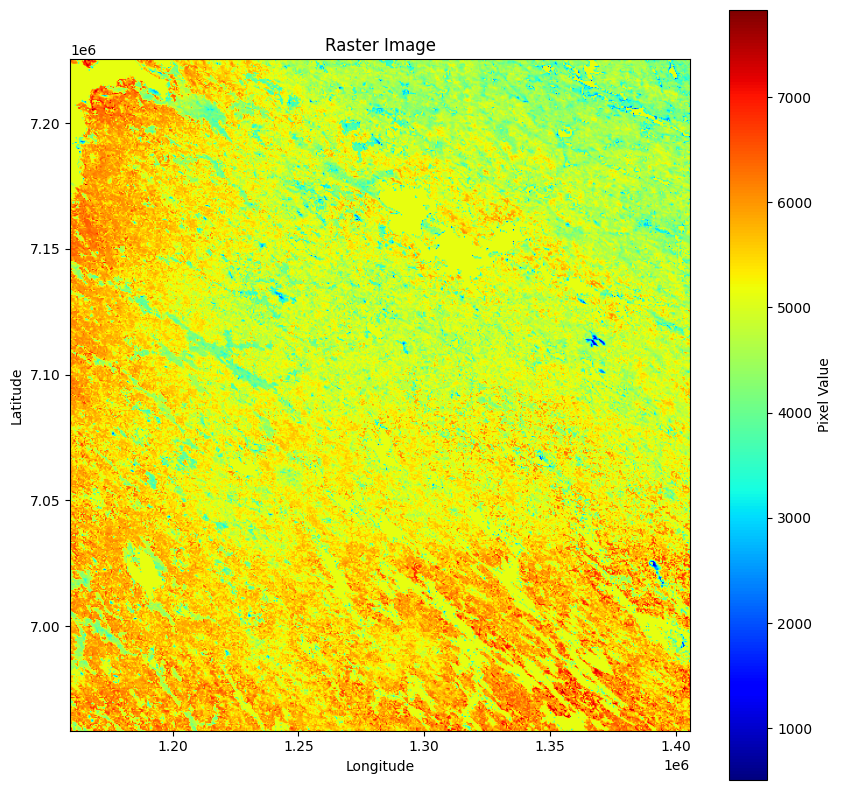

(576, 532)
Minimum value: 508


In [23]:
import rasterio
import matplotlib.pyplot as plt

# Open the raster file
file_path = "/content/npp/ID181N7225361_514252859S6958493_989532779W1159208_9167528471E1405690_2819456987.tif"
with rasterio.open(file_path) as dataset:
    # Read the raster data
    raster_data = dataset.read(1)  # Read the first band

    # Get the spatial transform (affine transformation matrix)
    transform = dataset.transform

    # Plot the raster image
    plt.figure(figsize=(10, 10))
    plt.imshow(raster_data, cmap='jet', extent=[transform[2], transform[2] + transform[0] * dataset.width,
                                                    transform[5] + transform[4] * dataset.height, transform[5]])
    plt.colorbar(label='Pixel Value')
    plt.title('Raster Image')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()
    print(raster_data.shape)
    # Calculate the minimum value
    min_value = raster_data.min()

print("Minimum value:", min_value)

In [24]:
import shutil

# Path to the folder you want to zip
folder_path = '/content/npp'

# Path and name for the destination zip file
destination_folder = '/content/MODISv2/npp'

# Use the shutil.move() function to move the folder
shutil.move(folder_path, destination_folder)

destination_zip_folder = '/content/MODISv2'
destination_zip_name = '/content/MODIS_NPP_2015_Redux'
# Create a zip file
shutil.make_archive(destination_zip_name, 'zip', destination_zip_folder)


'/content/MODIS_NPP_2015_Redux.zip'

<open DatasetReader name='/content/MODIS/npp/ID0N4828181_518937418S4561313_994217338W1410324_409110978E1699893_8569409258.tif' mode='r'>
PROJCS["Sinusoidal",GEOGCS["GCS_Undefined",DATUM["Undefined",SPHEROID["User_Defined_Spheroid",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Minimum Longitude: 1410323.909110978
Minimum Latitude: 4561313.694217338
Maximum Longitude: 1699894.3569409258
Maximum Latitude: 4828181.818937418
6676.5122 450 15159 857.3753666510655


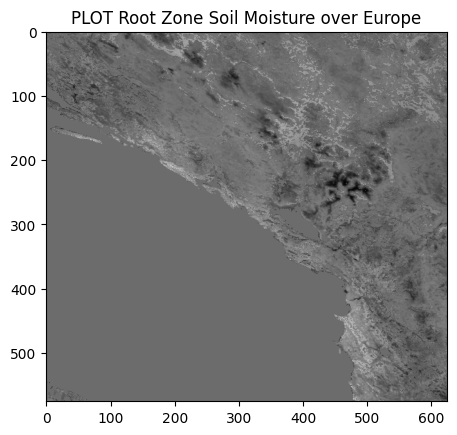

In [26]:
import rasterio
import matplotlib.pyplot as plt

# Open the GeoTIFF file using rasterio
with rasterio.open('/content/MODIS/npp/ID0N4828181_518937418S4561313_994217338W1410324_409110978E1699893_8569409258.tif') as src:
 # Read the raster data
    data = src.read(1)  # Read the first band
    print(src)
    test = src.crs
    print(src.crs)
    # Get information about the raster file
    meta = src.meta
    # Get the bounding box coordinates
    bounds = src.bounds

# Get the minimum and maximum longitude and latitude values
min_longitude, min_latitude, max_longitude, max_latitude = bounds.left, bounds.bottom, bounds.right, bounds.top

# Print the results
print("Minimum Longitude:", min_longitude)
print("Minimum Latitude:", min_latitude)
print("Maximum Longitude:", max_longitude)
print("Maximum Latitude:", max_latitude)


data = np.array(data)
# Find the smallest value
min_value = np.min(data)

# Compute the average without the smallest value
average = np.mean(data[data != min_value])

# Set the smallest value to the computed average
data[data == min_value] = average


# Plot the raster data
# data = (data-data.mean())/data.std()
# data[data < 0] = data[data > 0].min() - 1
 # we calibrate the data so that it displays significant results
print(data.mean(),data.min(),data.max(),data.std())
plt.imshow(data,cmap='gray')
plt.title('PLOT Root Zone Soil Moisture over Europe')
plt.show()

In [27]:
source_file_path = '/content/MODIS_NPP_2015_Redux.zip'
destination_drive_directory = '/content/drive/MyDrive/Colab Notebooks/VaesSOC/Data_Files_Redux/TifFilesRaster/'

shutil.move(source_file_path, destination_drive_directory)

'/content/drive/MyDrive/Colab Notebooks/VaesSOC/Data_Files_Redux/MODIS_NPP_2015_Redux.zip'